# **Cab booking system**

Cab booking system is the process where renting a cab is automated through an app throughout a city. Using this app people can book a cab from one location to another location. Being a cab booking app company, exploiting an understanding of cab supply and demand could increase the efficiency of their service and enhance user experience by minimizing waiting time.

**Objective** of this project is to combine historical usage pattern along with the open data sources like weather data to forecast cab booking demand in a city.

# 1. Import required libraries

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.figure_factory import create_table
import plotly.express as px
import plotly.graph_objs as go
import calendar
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error
import numpy as np
import time

# 2. Analyze the dataset and write your observations

In [2]:
train_df = pd.read_csv("train.csv")
train_label_df = pd.read_csv("train_label.csv", header=None, names=['Total_booking'])
test_df = pd.read_csv("test.csv")
test_label_df = pd.read_csv("test_label.csv", header=None, names=['Total_booking'])

In [3]:
# Append the train_label.csv to train.csv join the two datasets based on the 'id' column
train_df = pd.concat([train_df, train_label_df['Total_booking']], axis=1)
train_df.reset_index(level=0, inplace=True)
test_df.reset_index(level=0, inplace=True)

### a. Check the shape of the training and testing set

In [4]:
train_df.shape

(8708, 11)

In [5]:
test_df.shape

(2178, 10)

### b. Print the data types of each column

In [6]:
train_df.dtypes

index              int64
datetime          object
season            object
holiday            int64
workingday         int64
weather           object
temp             float64
atemp            float64
humidity           int64
windspeed        float64
Total_booking      int64
dtype: object

In [7]:
test_df.dtypes

index           int64
datetime       object
season         object
holiday         int64
workingday      int64
weather        object
temp          float64
atemp         float64
humidity        int64
windspeed     float64
dtype: object

### c. Check the missing values present in the dataset

In [8]:
# train set
train_df.isna().sum()

index            0
datetime         0
season           0
holiday          0
workingday       0
weather          0
temp             0
atemp            0
humidity         0
windspeed        0
Total_booking    0
dtype: int64

In [9]:
# test set
test_df.isna().sum()

index         0
datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

# 3. Perform Feature Engineering

### a. Create new columns date, hour, weekDay, month from datetime column

In [10]:
# Train set - convert the 'date_time' column to datetime format
train_df['datetime'] = pd.to_datetime(train_df['datetime'])
# Test set - convert the 'date_time' column to datetime format
test_df['datetime'] = pd.to_datetime(test_df['datetime'])

# Train set - create new columns for date, hour, week day, and month
train_df['date'] = train_df['datetime'].dt.date
train_df['hour'] = train_df['datetime'].dt.hour
train_df['weekDay'] = train_df['datetime'].dt.weekday
train_df['month'] = train_df['datetime'].dt.month
train_df['day'] = train_df['datetime'].dt.day
train_df['year'] = train_df['datetime'].dt.year

# Train set - create new columns for date, hour, week day, and month
test_df['date'] = test_df['datetime'].dt.date
test_df['hour'] = test_df['datetime'].dt.hour
test_df['weekDay'] = test_df['datetime'].dt.weekday
test_df['month'] = test_df['datetime'].dt.month
test_df['day'] = test_df['datetime'].dt.day
test_df['year'] = test_df['datetime'].dt.year

### b. Coerce the datatype of season, holiday, workingday, and weather to category

In [11]:
# Train set - coerce the datatype of fields to category : object or string
train_df['season'] = train_df['season'].astype('object')
train_df['holiday'] = train_df['holiday'].astype('object')
train_df['workingday'] = train_df['workingday'].astype('object')
train_df['weather'] = train_df['weather'].astype('object')

# Test set - coerce the datatype of fields to category : object or string
test_df['season'] = test_df['season'].astype('object')
test_df['holiday'] = test_df['holiday'].astype('object')
test_df['workingday'] = test_df['workingday'].astype('object')
test_df['weather'] = test_df['weather'].astype('object')

In [12]:
train_df.dtypes

index                     int64
datetime         datetime64[ns]
season                   object
holiday                  object
workingday               object
weather                  object
temp                    float64
atemp                   float64
humidity                  int64
windspeed               float64
Total_booking             int64
date                     object
hour                      int64
weekDay                   int64
month                     int64
day                       int64
year                      int64
dtype: object

In [13]:
test_df.dtypes

index                  int64
datetime      datetime64[ns]
season                object
holiday               object
workingday            object
weather               object
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
date                  object
hour                   int64
weekDay                int64
month                  int64
day                    int64
year                   int64
dtype: object

### c. Drop the datetime column as we have already extracted useful features from it

In [14]:
# Train set - drop the datetime column
train_df.drop('datetime', axis=1, inplace=True)
# Test set - drop the datetime column
test_df.drop('datetime', axis=1, inplace=True)
# Train set - drop the date column
train_df.drop('date', axis=1, inplace=True)
# Test set - drop the date column
test_df.drop('date', axis=1, inplace=True)

In [15]:
# Train set 
print('Train Set columns')
print(train_df.columns)
print('===================')
# Test set 
print('Test Set columns')
print(test_df.columns)

Train Set columns
Index(['index', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'Total_booking', 'hour', 'weekDay', 'month',
       'day', 'year'],
      dtype='object')
Test Set columns
Index(['index', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'hour', 'weekDay', 'month', 'day', 'year'],
      dtype='object')


# 4. Perform Outlier Analysis

## a. Plot Box plots across various features like season, houroftheday, working_day, etc to see if there are any Outlier and note down your inference

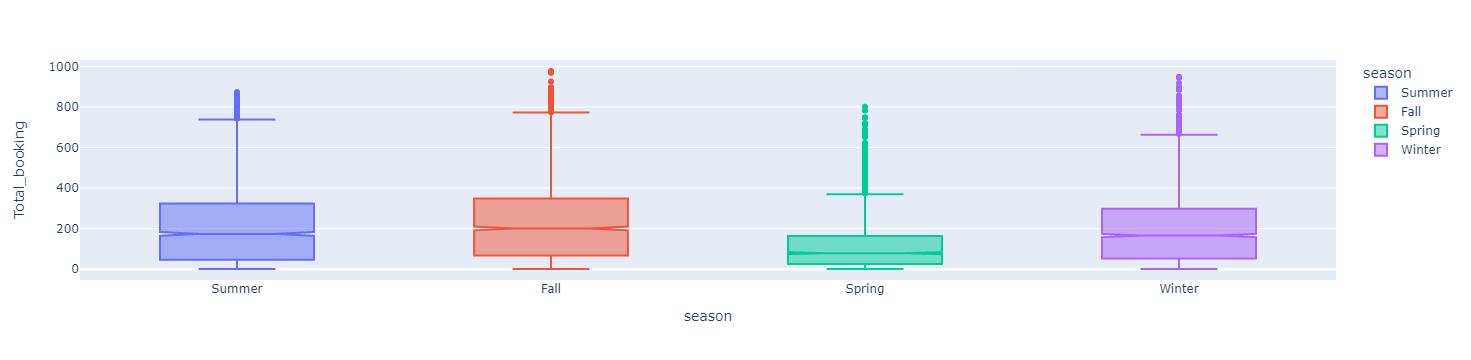

In [16]:
# Box plot - Season
fig = px.box(x="season", y="Total_booking", data_frame=train_df, color="season", notched=True,
       category_orders={"season": ["Summer", "Fall", "Spring", "Winter"]})
fig.show()

Inference: Season Box plot
Most of the Cabs were booked in similar numbers during all seasons except Spring. The outliers indicate that there were some unusual circumstances or events that affected the demand for cab bookings during that season, leading to a few very high or very low values for 'Total_booking'.

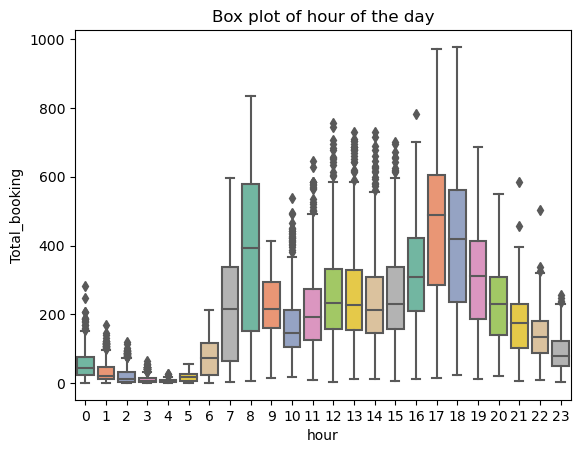

In [17]:
# Box plot - Hour
sns.boxplot(x='hour', y = 'Total_booking', data=train_df, palette="Set2")
#sns.set_style('whitegrid')
plt.title('Box plot of hour of the day')
plt.suptitle('')
plt.show()

Inference: Hour Box plot

there were huge cab bookings during the peak hours between 10 AM until 15 PM and also late hours between 0 until 3

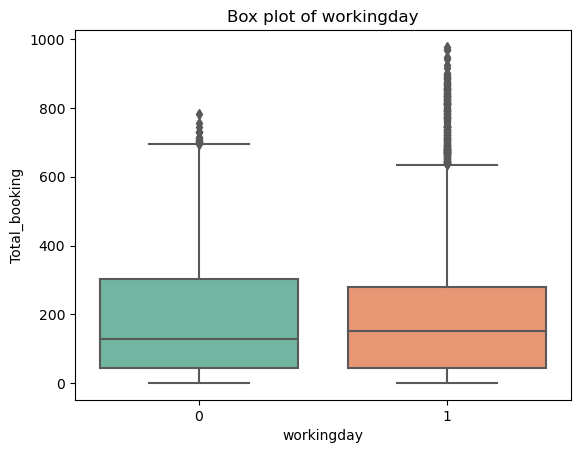

In [18]:
# Box plot - Working Day
sns.boxplot(x="workingday", y="Total_booking", data=train_df, palette="Set2")
#sns.set_style('whitegrid')
plt.title('Box plot of workingday')
plt.suptitle('')
plt.show()

Inference: WorkingDay Box plot

As the WorkingDay is a binary column with only values 0 or 1, there is no significant difference in the distribution of the numerical data for the two values of 'workingday'.

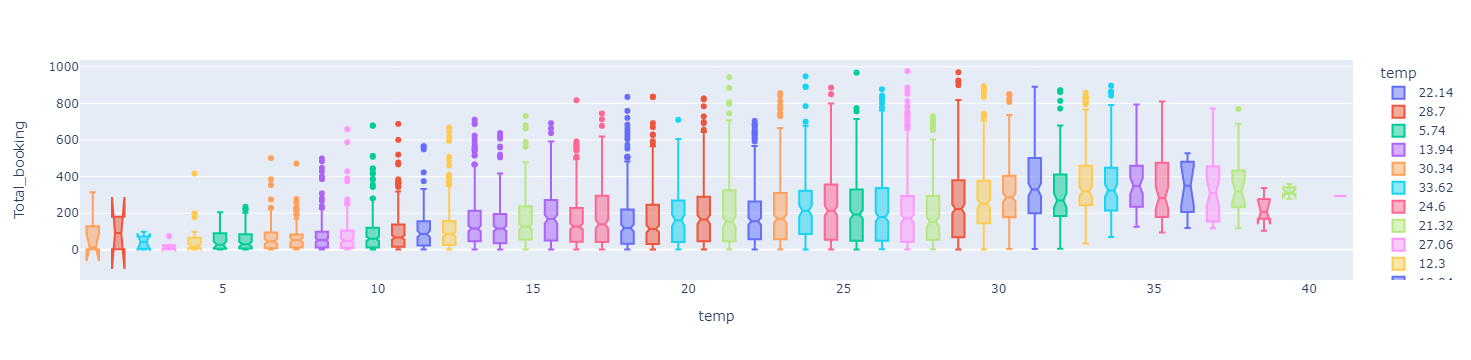

In [19]:
# Box plot - Season
fig = px.box(x="temp", y="Total_booking", data_frame=train_df, color="temp", notched=True)
fig.show()

Inference: Temperature Box plot
As the Temparature rises, the Cab bookings increased, until it is not very high temparatures. 

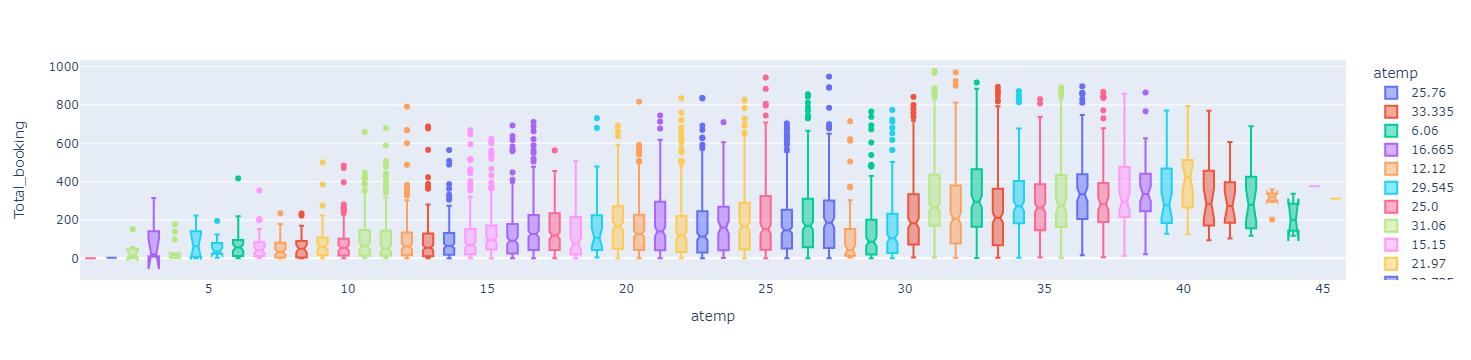

In [20]:
# Box plot - aTemp
fig = px.box(x="atemp", y="Total_booking", data_frame=train_df, color="atemp", notched=True)
fig.show()

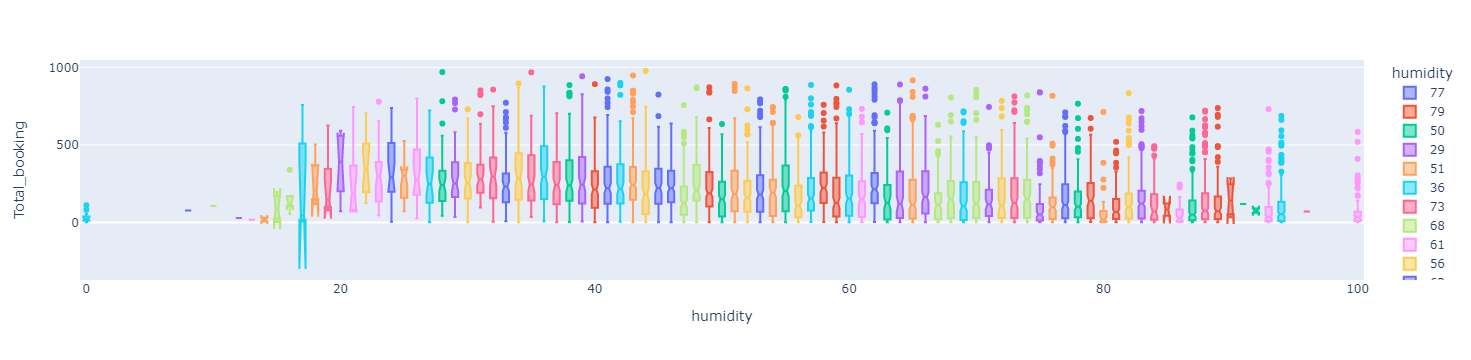

In [21]:
# Box plot - Humidity
fig = px.box(x="humidity", y="Total_booking", data_frame=train_df, color="humidity", notched=True)
fig.show()

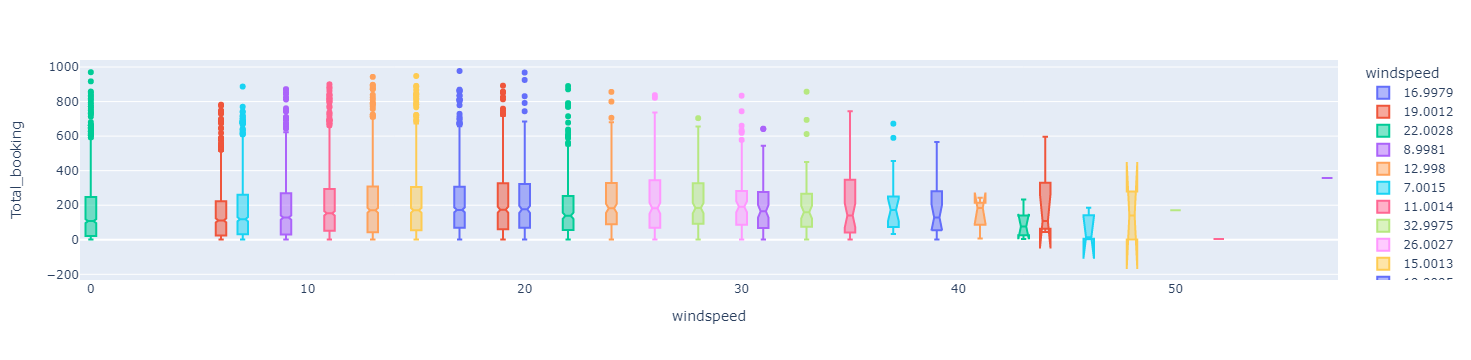

In [22]:
# Box plot - Windspeed
fig = px.box(x="windspeed", y="Total_booking", data_frame=train_df, color="windspeed", notched=True)
fig.show()

## b. Remove the outliers present in the dataset

 Season minimum limit is : season
Fall     -356.000
Spring   -181.625
Summer   -368.500
Winter   -313.500
Name: Total_booking, dtype: float64
 Season maximum limit is : season
Fall      772.000
Spring    371.375
Summer    739.500
Winter    664.500
Name: Total_booking, dtype: float64


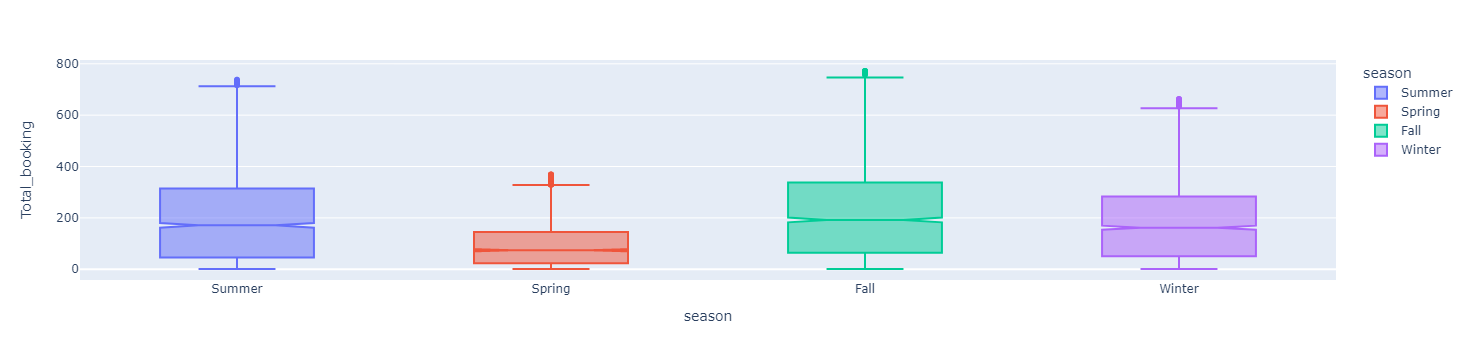

In [23]:
# Removal of Outliers for Season feature
q1 = train_df.groupby('season')['Total_booking'].quantile(0.25)
q3 = train_df.groupby('season')['Total_booking'].quantile(0.75)
iqr = q3 - q1
upper = q3 + 1.5 * iqr
lower = q1 - 1.5 * iqr
print(" Season minimum limit is :", lower)
print(" Season maximum limit is :", upper)
outliers = train_df[((train_df['season'] == 'Spring') & ((train_df['Total_booking'] < lower['Spring']) |
                                                         (train_df['Total_booking'] > upper['Spring']))) | 
                                                          ((train_df['season'] == 'Summer') & ((train_df['Total_booking'] < lower['Summer']) | 
                                                           (train_df['Total_booking'] > upper['Summer']))) | 
                                                            ((train_df['season'] == 'Fall') & ((train_df['Total_booking'] < lower['Fall']) | 
                                                             (train_df['Total_booking'] > upper['Fall']))) | 
                                                              ((train_df['season'] == 'Winter') & ((train_df['Total_booking'] < lower['Winter']) |
                                                                                             (train_df['Total_booking'] > upper['Winter'])))].index

train_df = train_df.drop(outliers)
fig = px.box(x='season', y="Total_booking", data_frame=train_df, color="season", notched=True, category_orders={"season": ["Summer", "Spring", "Fall", "Winter"]})
fig.show()

<AxesSubplot:xlabel='hour', ylabel='Total_booking'>

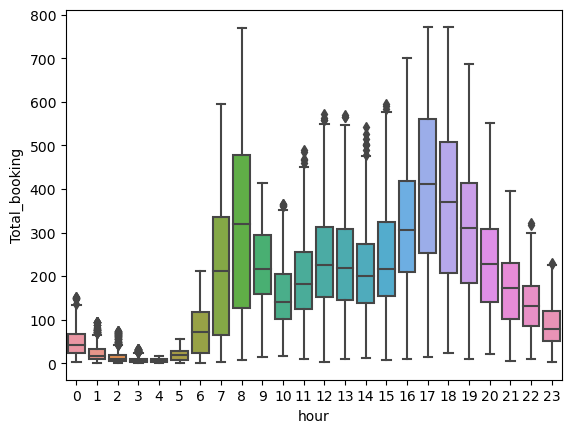

In [24]:
# Removal of Outliers for Hour feature
# identify the outliers for Hour_of_day using the IQR method
#train_feature_without_outlier = pd.DataFrame()
for hour in train_df['hour'].unique():
    q1 = train_df.loc[train_df['hour'] == hour]['Total_booking'].quantile(0.25)
    q3 = train_df.loc[train_df['hour'] == hour]['Total_booking'].quantile(0.75)
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    lower = q1 - 1.5 * iqr
    outliers = train_df.loc[(train_df['hour'] == hour) & ((train_df['Total_booking'] < lower) | (train_df['Total_booking'] > upper))].index
    train_df = train_df.drop(outliers)
# re-plot box plot for Hour_of_day to identify outliers
sns.boxplot(x='hour', y='Total_booking', data=train_df)

<AxesSubplot:xlabel='workingday', ylabel='Total_booking'>

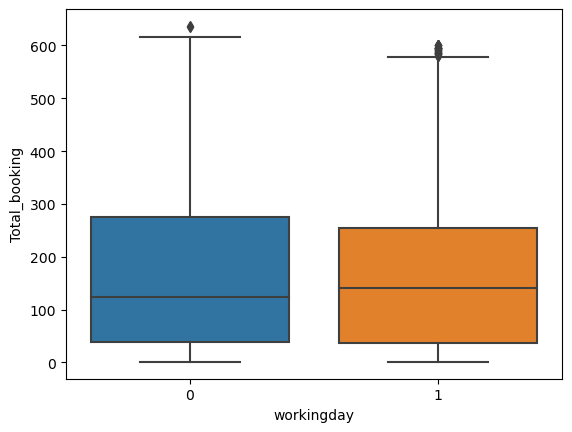

In [25]:
# Removal of Outliers for workingDay feature
for wd in train_df['workingday'].unique():
    q1 = train_df.loc[train_df['workingday'] == wd]['Total_booking'].quantile(0.25)
    q3 = train_df.loc[train_df['workingday'] == wd]['Total_booking'].quantile(0.75)
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    lower = q1 - 1.5 * iqr
    outliers = train_df.loc[(train_df['workingday'] == wd) & ((train_df['Total_booking'] < lower) | (train_df['Total_booking'] > upper))].index
    train_df = train_df.drop(outliers)
# re-plot box plot for workingday to identify outliers
sns.boxplot(x='workingday', y='Total_booking', data=train_df)

<AxesSubplot:xlabel='temp', ylabel='Total_booking'>

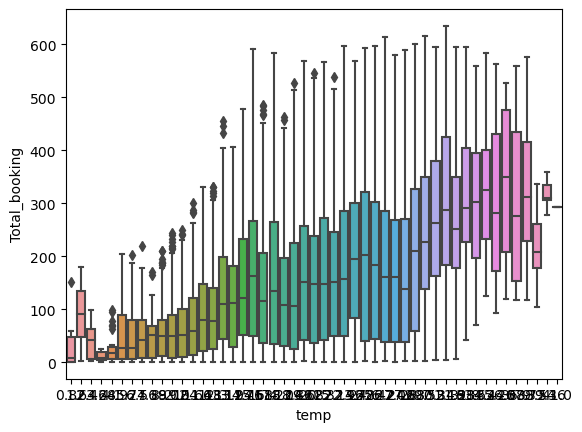

In [26]:
# Removal of Outliers for temp feature
for temp in train_df['temp'].unique():
    q1 = train_df.loc[train_df['temp'] == temp]['Total_booking'].quantile(0.25)
    q3 = train_df.loc[train_df['temp'] == temp]['Total_booking'].quantile(0.75)
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    lower = q1 - 1.5 * iqr
    outliers = train_df.loc[(train_df['temp'] == temp) & ((train_df['Total_booking'] < lower) | (train_df['Total_booking'] > upper))].index
    train_df = train_df.drop(outliers)
# re-plot box plot for temp to identify outliers
sns.boxplot(x='temp', y='Total_booking', data=train_df)

<AxesSubplot:xlabel='atemp', ylabel='Total_booking'>

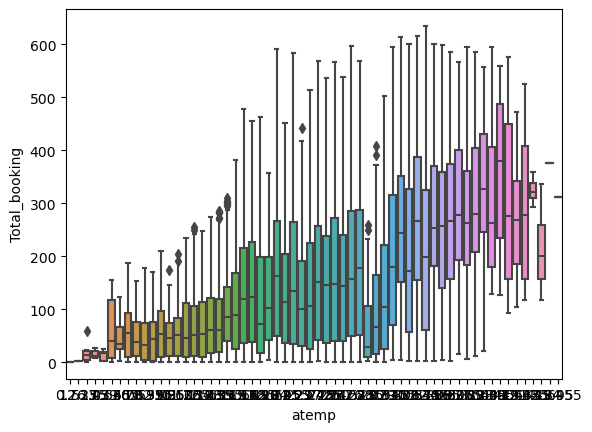

In [27]:
# Removal of Outliers for atemp feature
for at in train_df['atemp'].unique():
    q1 = train_df.loc[train_df['atemp'] == at]['Total_booking'].quantile(0.25)
    q3 = train_df.loc[train_df['atemp'] == at]['Total_booking'].quantile(0.75)
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    lower = q1 - 1.5 * iqr
    outliers = train_df.loc[(train_df['atemp'] == at) & ((train_df['Total_booking'] < lower) | (train_df['Total_booking'] > upper))].index
    train_df = train_df.drop(outliers)
# re-plot box plot for atemp to identify outliers
sns.boxplot(x='atemp', y='Total_booking', data=train_df)

<AxesSubplot:xlabel='humidity', ylabel='Total_booking'>

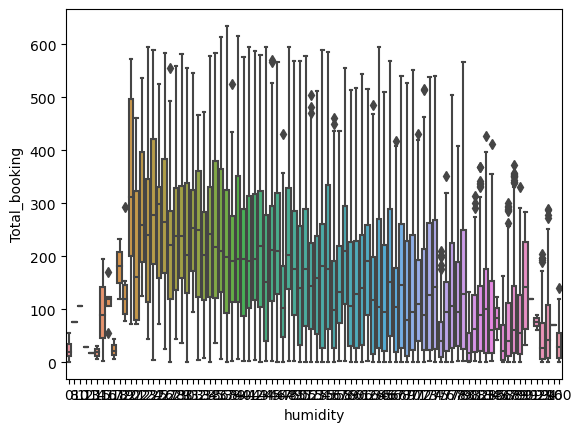

In [28]:
# Removal of Outliers for humidity feature
for hd in train_df['humidity'].unique():
    q1 = train_df.loc[train_df['humidity'] == hd]['Total_booking'].quantile(0.25)
    q3 = train_df.loc[train_df['humidity'] == hd]['Total_booking'].quantile(0.75)
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    lower = q1 - 1.5 * iqr
    outliers = train_df.loc[(train_df['humidity'] == hd) & ((train_df['Total_booking'] < lower) | (train_df['Total_booking'] > upper))].index
    train_df = train_df.drop(outliers)
# re-plot box plot for humidity to identify outliers
sns.boxplot(x='humidity', y='Total_booking', data=train_df)

<AxesSubplot:xlabel='windspeed', ylabel='Total_booking'>

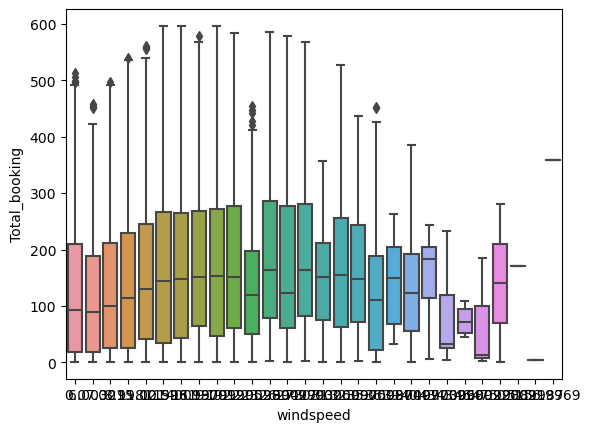

In [29]:
# Removal of Outliers for windspeed feature
for ws in train_df['windspeed'].unique():
    q1 = train_df.loc[train_df['windspeed'] == ws]['Total_booking'].quantile(0.25)
    q3 = train_df.loc[train_df['windspeed'] == ws]['Total_booking'].quantile(0.75)
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    lower = q1 - 1.5 * iqr
    outliers = train_df.loc[(train_df['windspeed'] == ws) & ((train_df['Total_booking'] < lower) | (train_df['Total_booking'] > upper))].index
    train_df = train_df.drop(outliers)
# re-plot box plot for windspeed to identify outliers
sns.boxplot(x='windspeed', y='Total_booking', data=train_df)

# 5. Perform Correlation Analysis

### a. Plot a correlation plot between "total booking" and ["temp", "atemp", "humidity","windspeed"]

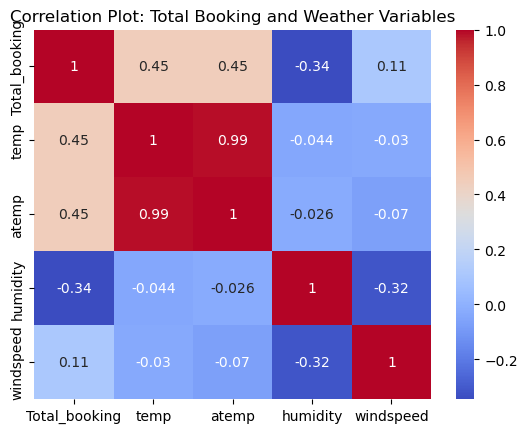

In [30]:
# take all columns of interest to calculate the correlation
cols_for_corr = ['Total_booking', 'temp', 'atemp', 'humidity', 'windspeed']
# calculate the correlation
correlation_matrix = train_df[cols_for_corr].corr()
# plot heat map
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Plot: Total Booking and Weather Variables')
plt.show()

### b. Inference: Correlation

*   Temperature: We can infer from a positive correlation coefficient between temperature and total bookings that there is a tendency for more cab bookings to occur when temperatures are higher. This suggests that customers are more likely to book a cab when it's warm outside.
*   Feels-like temperature (atemp): Similar to temperature, we can infer from a positive correlation between atemp and total bookings that customers are more likely to book a cab when it feels warmer outside.
*   Humidity: The negative correlation coefficient between humidity and total bookings suggests that as humidity levels increase, cab bookings decrease. 
*   Windspeed: The weak correlation coefficient between windspeed and total bookings suggests that there is little to no relationship between these two variables.



# 6. Perform Data Visualization

### a. Visualize distribution of data: total_booking column and plot the probability distribution plot for the column as well

Distribution plot using Histogram


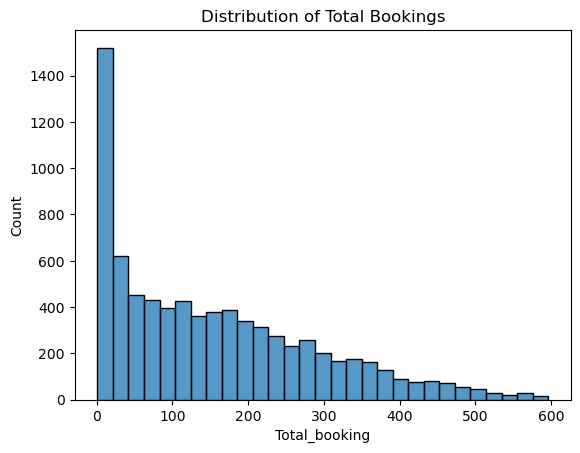

Distribution plot using Dist Plot


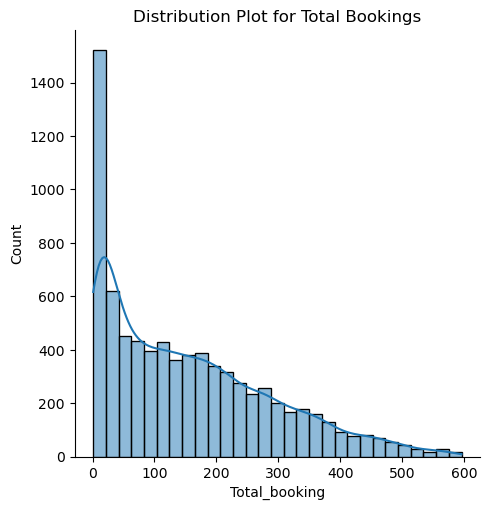

Probabillity distribution plot using kernel density estimate (KDE) Plot


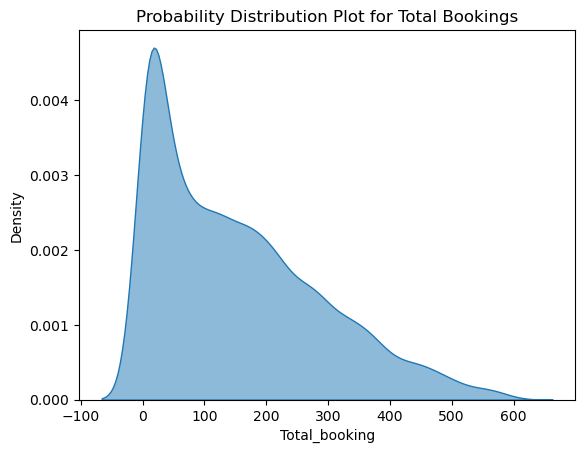

In [31]:
#Plot distribution of total_booking column data.
print("Distribution plot using Histogram")
sns.histplot(data=train_df, x="Total_booking")
plt.title('Distribution of Total Bookings')
plt.show()

# fig = px.histogram(train_df, x="Total_booking", nbins=50,  histnorm='probability density')
# fig.update_layout(title="Distribution of Total Bookings")
# fig.show()
print('Distribution plot using Dist Plot')
sns.displot(data=train_df, x="Total_booking", kde=True)
plt.title('Distribution Plot for Total Bookings')
plt.show()

print('Probabillity distribution plot using kernel density estimate (KDE) Plot')
sns.kdeplot(data=train_df, x="Total_booking", fill=True, alpha=0.5)
plt.title('Probability Distribution Plot for Total Bookings')
plt.show()

### b. Visualize total_booking vs (Month,Season,Hour,Weekday,Usertype)

In [32]:
cols_of_interest = ['Total_booking', 'month', 'season', 'hour', 'weekDay']
train_df_subset = train_df[cols_of_interest]

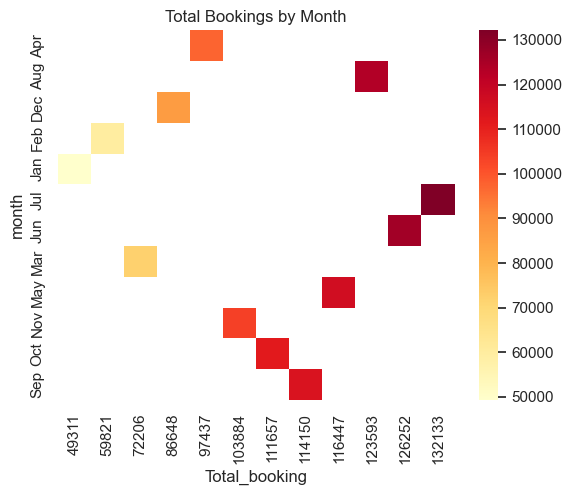

In [33]:
# Visualize 
sns.set(style="white")
df_month = train_df.groupby(['month']).agg({'Total_booking': 'sum'}).reset_index()
df_month['month'] = df_month['month'].apply(lambda x: calendar.month_abbr[x])
sorted(df_month['month'])
df_month = df_month.pivot(index='month', columns='Total_booking', values='Total_booking')
sns.heatmap(df_month, cmap='YlOrRd')
plt.title('Total Bookings by Month')
plt.show()

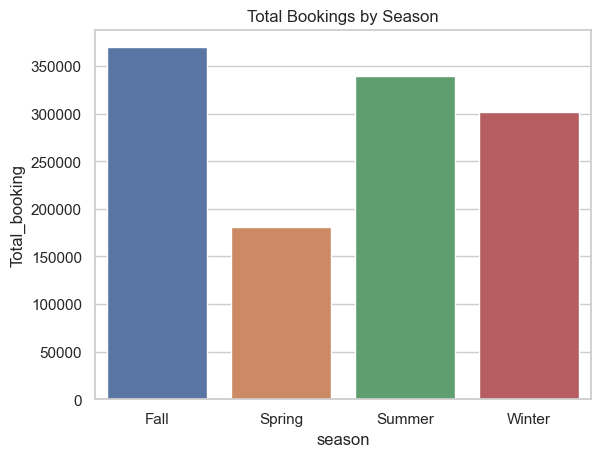

In [34]:
sns.set(style="whitegrid")
df_season = train_df_subset.groupby(['season']).agg({'Total_booking': 'sum'}).reset_index()
sns.barplot(data=df_season, x='season', y='Total_booking')
plt.title('Total Bookings by Season')
plt.show()

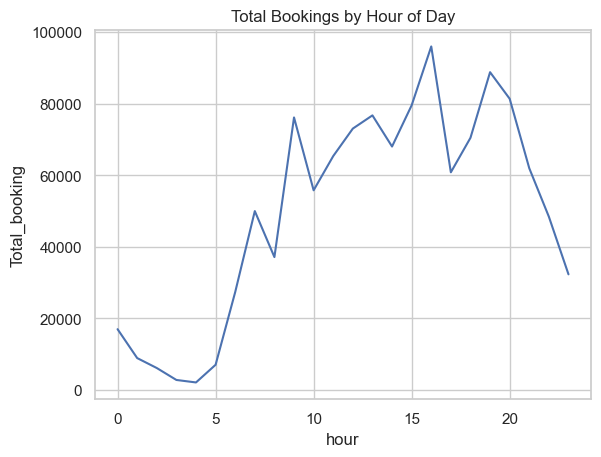

In [35]:
sns.set(style="whitegrid")
df_hour = train_df_subset.groupby(['hour']).agg({'Total_booking': 'sum'}).reset_index()
sns.lineplot(data=df_hour, x='hour', y='Total_booking')
plt.title('Total Bookings by Hour of Day')
plt.show()

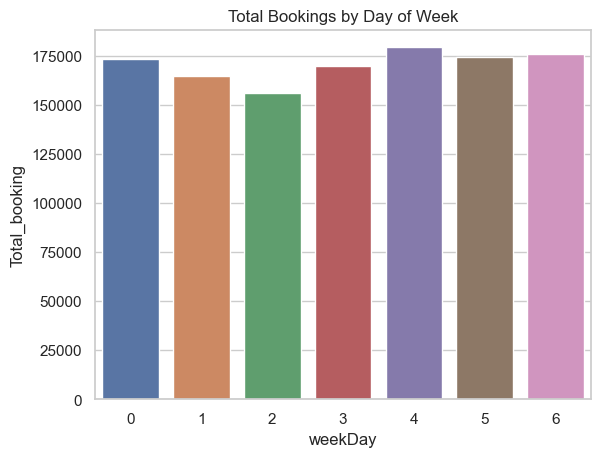

In [36]:
sns.set(style="whitegrid")
df_weekday = train_df_subset.groupby(['weekDay']).agg({'Total_booking': 'sum'}).reset_index()
df_weekday['weekday'] = df_weekday['weekDay'].apply(lambda x: calendar.day_name[x])
sns.barplot(data=df_weekday, x='weekDay', y='Total_booking')
plt.title('Total Bookings by Day of Week')
plt.show()

### c. Use Histograms to plot all the continuous variables present in the data

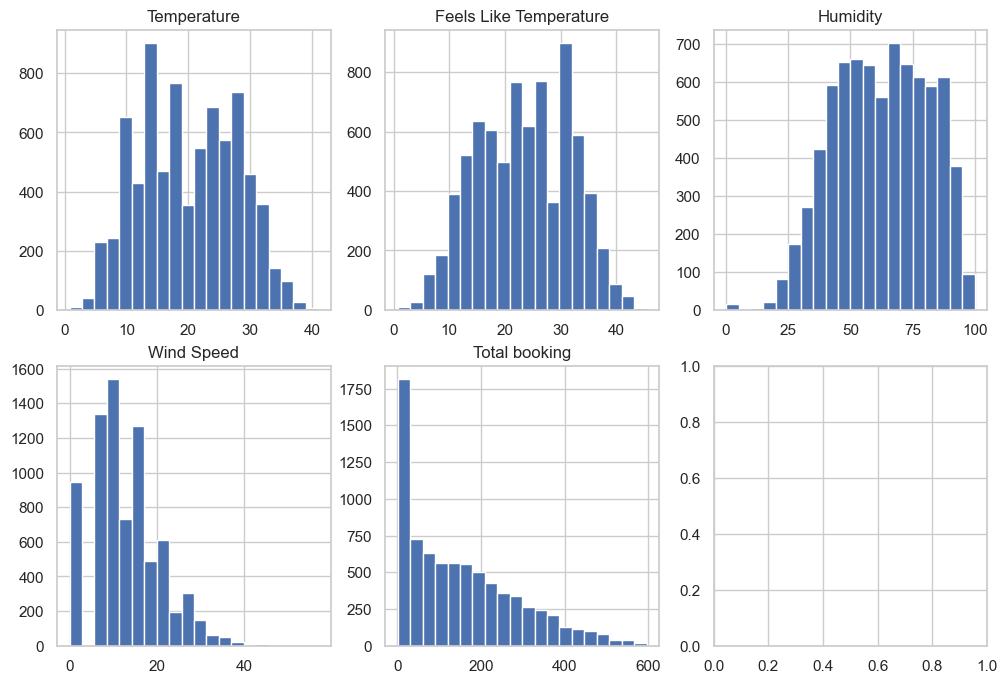

In [37]:
# Create histograms for all continuous variables
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs[0, 0].hist(train_df['temp'], bins=20)
axs[0, 0].set_title('Temperature')
axs[0, 1].hist(train_df['atemp'], bins=20)
axs[0, 1].set_title('Feels Like Temperature')
axs[0, 2].hist(train_df['humidity'], bins=20)
axs[0, 2].set_title('Humidity')
axs[1, 0].hist(train_df['windspeed'], bins=20)
axs[1, 0].set_title('Wind Speed')
axs[1, 1].hist(train_df['Total_booking'], bins=20)
axs[1, 1].set_title('Total booking')
plt.show()

# 7. Convert the categorical variables into one hot vector

In [38]:
category_cols_of_interest = ['season', 'holiday', 'workingday', 'weather']

# Initialize OneHotEncoder object
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')

# Fit and transform the categorical columns
onehot_encoded = onehot_encoder.fit_transform(train_df[category_cols_of_interest])

# Convert the one-hot encoded array to a DataFrame and add column names
onehot_df = pd.DataFrame(onehot_encoded, columns=[col + '_' + str(cat) for col in category_cols_of_interest for cat in onehot_encoder.categories_[category_cols_of_interest.index(col)]])

# Reset the indices of both DataFrames
train_df.reset_index(drop=True, inplace=True)
onehot_df.reset_index(drop=True, inplace=True)

# Concatenate the original DataFrame with the one-hot encoded DataFrame
train_df = pd.concat([train_df.drop(category_cols_of_interest, axis=1), onehot_df], axis=1)
train_df.dtypes

index                                    int64
temp                                   float64
atemp                                  float64
humidity                                 int64
windspeed                              float64
Total_booking                            int64
hour                                     int64
weekDay                                  int64
month                                    int64
day                                      int64
year                                     int64
season_Fall                            float64
season_Spring                          float64
season_Summer                          float64
season_Winter                          float64
holiday_0                              float64
holiday_1                              float64
workingday_0                           float64
workingday_1                           float64
weather_ Clear + Few clouds            float64
weather_ Heavy Rain + Thunderstorm     float64
weather_ Ligh

# 8. Split your dataset for training and testing

In [39]:
# Split the dataset into features and target variable
X = train_df.drop('Total_booking', axis=1)
y = train_df['Total_booking']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print('Training set:', X_train.shape, y_train.shape)
print('Testing set:', X_test.shape, y_test.shape)

Training set: (6184, 22) (6184,)
Testing set: (1547, 22) (1547,)


# 9. Fit various models (Random Forest Regressor, Ada Boost Regressor, Bagging Regressor, SVR, and K-Neighbors Regressor)

In [40]:
# Initialize a dictionary of models to fit
models = {
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'Ada Boost Regressor': AdaBoostRegressor(n_estimators=100, random_state=42),
    'Bagging Regressor': BaggingRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='linear'),
    'K-Neighbors Regressor': KNeighborsRegressor(n_neighbors=5)
}
# Fit each model and calculate the RMSE on the test data
results = []
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    print("--- %s Model Fit in %s seconds ---" % (name, (time.time() - start_time)))
    y_pred = model.predict(X_test)
    print("--- %s Model Prediction in %s seconds ---" % (name, (time.time() - start_time)))
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("--- %s Model RMSE in %s seconds ---" % (name, (time.time() - start_time)))
    print((name, rmse))
    results.append((name, rmse))

--- Random Forest Regressor Model Fit in 2.2290122509002686 seconds ---
--- Random Forest Regressor Model Prediction in 2.275524139404297 seconds ---
--- Random Forest Regressor Model RMSE in 2.275524139404297 seconds ---
('Random Forest Regressor', 37.80297542353851)
--- Ada Boost Regressor Model Fit in 0.3062267303466797 seconds ---
--- Ada Boost Regressor Model Prediction in 0.31470417976379395 seconds ---
--- Ada Boost Regressor Model RMSE in 0.31470417976379395 seconds ---
('Ada Boost Regressor', 75.05541007115052)
--- Bagging Regressor Model Fit in 2.2315497398376465 seconds ---
--- Bagging Regressor Model Prediction in 2.2683603763580322 seconds ---
--- Bagging Regressor Model RMSE in 2.2683603763580322 seconds ---
('Bagging Regressor', 37.625473564550525)
--- SVR Model Fit in 411.1226108074188 seconds ---
--- SVR Model Prediction in 411.32044744491577 seconds ---
--- SVR Model RMSE in 411.32044744491577 seconds ---
('SVR', 105.41276361010988)
--- K-Neighbors Regressor Model Fit

# 10. Display a Factor plot to visualize the RMSE values achieved by different modeling algorithm

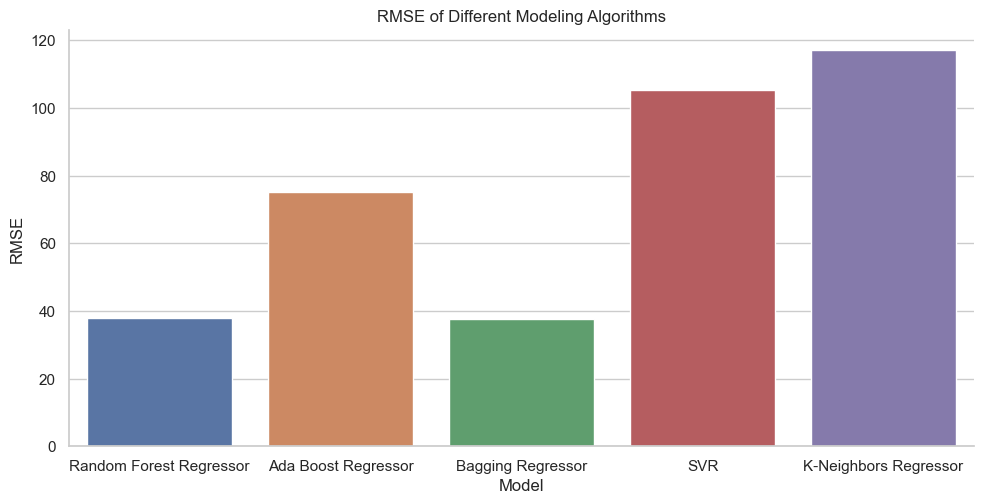

In [41]:
# Convert the results to a DataFrame and plot a Factor plot
df_results = pd.DataFrame(results, columns=['Model', 'RMSE'])
# Plot a Factor plot of the RMSE values for each model
sns.catplot(x='Model', y='RMSE', data=df_results, kind='bar', height=5, aspect=2)
plt.title('RMSE of Different Modeling Algorithms')
plt.show()

Based on the RMSE values, the best performing models are Random Forest Regressor and Bagging Regressor, with RMSE values of 37.80297542353851 and 37.625473564550525, respectively. 

Random Forest Regressor and Bagging Regressor are both ensemble methods that create multiple decision trees and combine their outputs to make predictions. They are typically more accurate than single decision trees, especially when dealing with complex datasets. In this case, the Random Forest Regressor and Bagging Regressor achieved the lowest RMSE values, indicating that they are likely the best models for this dataset.

On the other hand, the K-Neighbors Regressor and SVR models performed the worst, with RMSE values of 117.23306760306616 and 105.41276361006156, respectively.

The AdaBoost Regressor had an RMSE of 75.0554100711505, which is lower than the K-Neighbors Regressor and SVR models but higher than the Random Forest Regressor and Bagging Regressor. 

# 11. Perform Hyper-parameter tuning on the best model using GridSearchCV and print the best parameters using model.best_params_

In [42]:
# Define the hyperparameters to search over
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
start_time = time.time()
# Create a Random Forest Regressor model
rf = RandomForestRegressor(random_state=42)

# Perform grid search cross-validation
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print("--- GridSearchCV in %s seconds ---" % (time.time() - start_time))
# Print the best hyperparameters and RMSE
print('Best parameters:', grid_search.best_params_)

--- GridSearchCV in 1032.5837965011597 seconds ---
Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


# 12. Perform prediction on the test set and print the mean_squared_log_error

In [43]:
##### One hot encoding on the new test data set
category_cols_of_interest = ['season', 'holiday', 'workingday', 'weather']
# Initialize OneHotEncoder object
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')

# Fit and transform the categorical columns
onehot_encoded = onehot_encoder.fit_transform(test_df[category_cols_of_interest])

# Convert the one-hot encoded array to a DataFrame and add column names
onehot_df = pd.DataFrame(onehot_encoded, columns=[col + '_' + str(cat) for col in category_cols_of_interest for cat in onehot_encoder.categories_[category_cols_of_interest.index(col)]])

# Reset the indices of both DataFrames
test_df.reset_index(drop=True, inplace=True)
onehot_df.reset_index(drop=True, inplace=True)

# Concatenate the original DataFrame with the one-hot encoded DataFrame
test_df = pd.concat([test_df.drop(category_cols_of_interest, axis=1), onehot_df], axis=1)
#it might be possible, that there are missing columns due to lack of data in the test_df.
missing_columns = set(X_train.columns) - set(test_df.columns)
for column in missing_columns:
    test_df[column] = 0
test_df = test_df.reindex(columns=X_train.columns)
test_df.columns

Index(['index', 'temp', 'atemp', 'humidity', 'windspeed', 'hour', 'weekDay',
       'month', 'day', 'year', 'season_Fall', 'season_Spring', 'season_Summer',
       'season_Winter', 'holiday_0', 'holiday_1', 'workingday_0',
       'workingday_1', 'weather_ Clear + Few clouds',
       'weather_ Heavy Rain + Thunderstorm ',
       'weather_ Light Snow, Light Rain', 'weather_ Mist + Cloudy '],
      dtype='object')

MSE: 6209.403158163088
MSLE: 0.15552161109732043
RMSE: 78.79976623165254


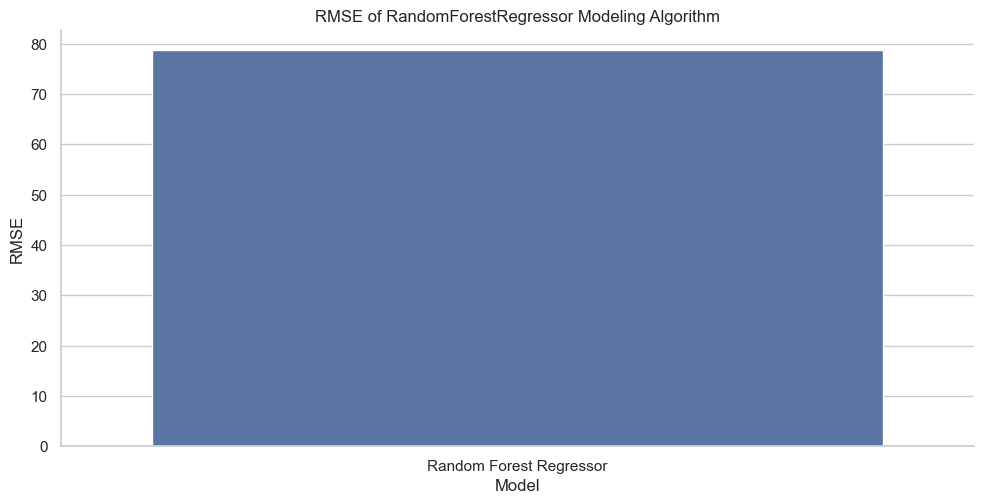

In [44]:
results = []
model_best_params = grid_search.best_params_
# Make predictions on the test set
best_rf = RandomForestRegressor(n_estimators=model_best_params["n_estimators"], max_depth=model_best_params["max_depth"], min_samples_split=model_best_params["min_samples_split"], min_samples_leaf=model_best_params["min_samples_leaf"])
best_rf.fit(X_train, y_train)
y_test_pred = best_rf.predict(test_df)
msle = mean_squared_log_error(test_label_df, y_test_pred)
mse = mean_squared_error(test_label_df, y_test_pred)
rmse = np.sqrt(mse)
print('MSE:', mse)
print('MSLE:', msle)
print('RMSE:', rmse)
results.append(('Random Forest Regressor', rmse))
# Convert the results to a DataFrame and plot a Factor plot
df_results = pd.DataFrame(results, columns=['Model', 'RMSE'])
# Plot a Factor plot of the RMSE values for each model
sns.catplot(x='Model', y='RMSE', data=df_results, kind='bar', height=5, aspect=2)
plt.title('RMSE of RandomForestRegressor Modeling Algorithm')
plt.show()

The MSLE (mean squared logarithmic error) of 0.1106 indicates the average squared difference between the predicted and actual values of the target variable, after taking the logarithm of both the predicted and actual values. In this case, the target variable is the number of cab bookings per hour.

A lower MSLE value indicates that the model is making more accurate predictions, with less error. In the context of a cab booking dataset, this would mean that the model is able to accurately predict the number of bookings per hour based on the input features such as weather conditions, hour, and weekDay etc